<h1>Обучение нейронной сети на наборе данных MNIST с использованием TensorFlow

In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# 1 <b><span style="color:#27aee3; font-weight:1200">|</span> Required Libraries

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter

import scipy as sp

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 2 <b><span style="color:#27aee3; font-weight:1200">|</span> Data

In [ ]:
train = pd.read_csv('/content/train.csv')

print(f'{train.shape}\n')
train.head()

(42000, 785)



,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
test = pd.read_csv('/content/test.csv')

print(f'{test.shape}\n')
test.head()

(28000, 784)



,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 3 <b><span style="color:#27aee3; font-weight:1200">|</span> Data Preprocessing

In [ ]:
x_train = train.values[:, 1:] # # получаем все значения, начиная с 1-го индекса и далее
y_train = train.values[:, 0]  # получаем столбец с меткой
x_test = test.values[:, 0:]   # получаем все значения, начиная с 0-го индекса

del train # delete train and test set to free up memory
del test

### <b><span style="color:#27aee3; font-weight:1200">※</span> Some of the training set contents<br/>

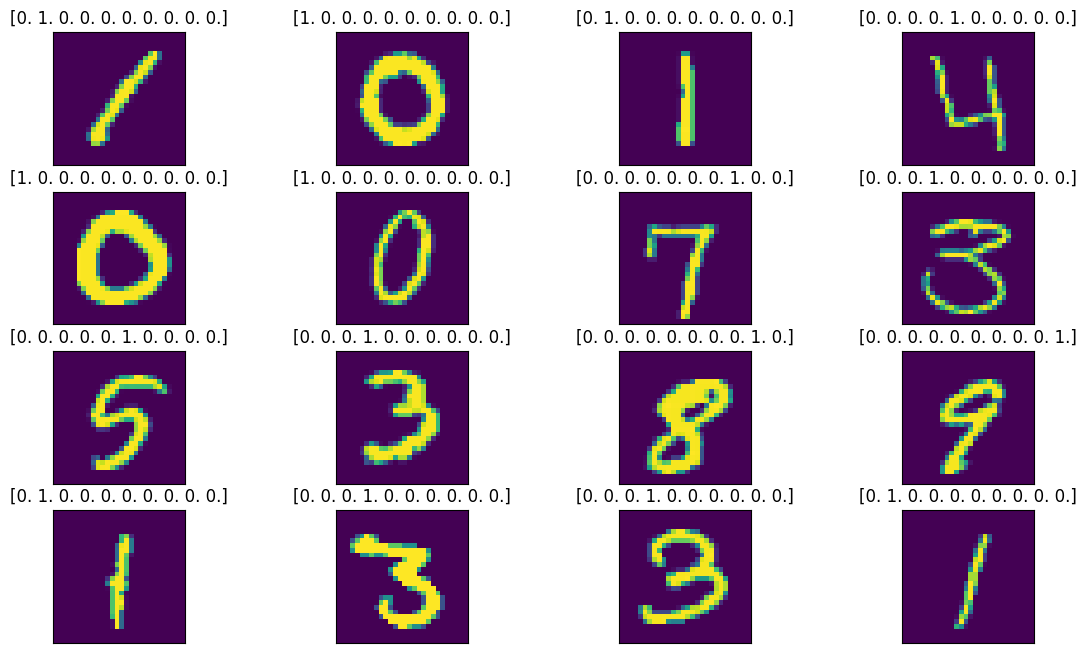

In [50]:
fig = plt.figure(figsize=[14, 10])

for i in range(16):
    ax = fig.add_subplot(5 , 4, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape((28,28)))
    ax.set_title(str(y_train[i]))

### <b><span style="color:#27aee3; font-weight:1200">※</span> Normalizing the pixel values

In [ ]:
mean = np.mean(x_train) # take the mean
std = np.std(x_train)   # take the standard deviation
x_train = (x_train-mean)/(std+1e-7)    # normalizing the values
x_test = (x_test-mean)/(std+1e-7)

x_train = x_train.reshape(-1, 28, 28, 1) # reshaping them
x_test = x_test.reshape(-1, 28, 28, 1)

y_train

array([1, 0, 1, ..., 7, 6, 9])

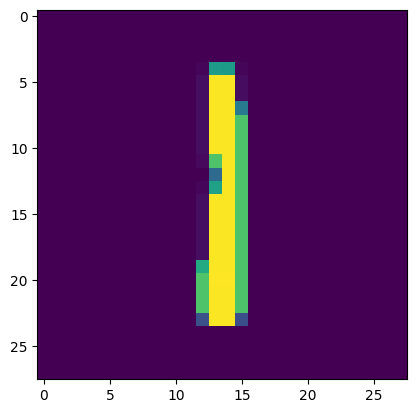

In [ ]:
plt.imshow(x_train[2])

In [ ]:
y_train[2]

1

In [ ]:
num_classes = 10

y_train = to_categorical(y_train, num_classes=num_classes)

x_train, x_val = x_train[:37000], x_train[37000:]
y_train, y_val = y_train[:37000], y_train[37000:]

print(f'Training samples: {x_train.shape}\nValidation samples: {x_val.shape}\nTesting samples: {x_test.shape}')

Training samples: (37000, 28, 28, 1)
Validation samples: (5000, 28, 28, 1)
Testing samples: (28000, 28, 28, 1)


# 4 <b><span style="color:#27aee3; font-weight:1200">|</span> CNN Model

In [ ]:
# Создание модели Sequential для
#последовательного стекирования слоёв.

model = Sequential()

# Обратите внимание на параметр padding,
#чтобы восстановить потерянные пиксели у границ при
#свертке.
model.add(Conv2D(16, input_shape=(28,28,1),
                 kernel_size=(3,3), activation='relu',
                 padding='same'))

# Пуллинг слой со стридом 2 уменьшит размер
#изображения вдвое.
model.add(MaxPooling2D(pool_size=(2,2)))

# Проход через дополнительные сверточные
# слои с увеличением числа фильтров.
model.add(Conv2D(32, kernel_size=(3,3),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3),
                 activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128, kernel_size=(3,3),
                 activation='relu', padding='same'))

# Использование глобального усреднения
#для учёта пикселей с меньшей интенсивностью.
model.add(GlobalAveragePooling2D())

# Вывод вероятностей классов.
model.add(Dense(10, activation='softmax'))

# Вывод краткой информации о модели.
model.summary()

# Компиляция модели с оптимизатором Adam, функцией потерь categorical_crossentropy и метрикой accuracy.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 3, 3, 64)         

# 5 <b><span style="color:#27aee3; font-weight:1200">|</span> Data Augmentation

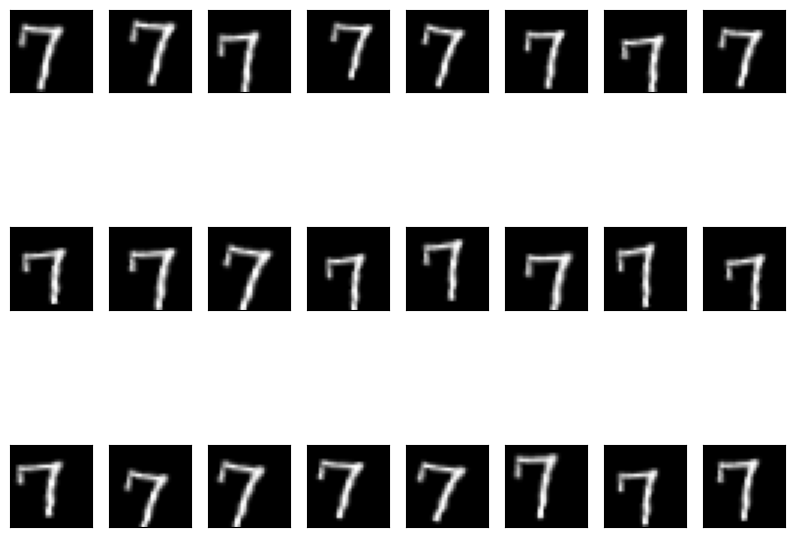

In [ ]:
datagen = ImageDataGenerator(
                rotation_range=10,
                zoom_range = 0.10,
                width_shift_range=0.1,
                height_shift_range=0.1
)

aug = datagen.flow(x_train[6].reshape(-1, 28, 28, 1))

fig = plt.figure(figsize=[10, 8])
for i in range(24):

    ax = fig.add_subplot(3, 8, i+1, xticks=[], yticks=[])
    aug_img = next(aug)[0]
    ax.imshow(aug_img, cmap = 'gray')

plt.show()

# 6 <b><span style="color:#27aee3; font-weight:1200">|</span> Network Training

LearningRateScheduler is used to update the learning rate with each new epoch.

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x) #ошибиться
epochs = 10
batch_size = 64
hist = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs = epochs,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data = (x_val, y_val),
    callbacks = [annealer],
    verbose = 1)

Epoch 1/10
578/578 [==============================] - 44s 74ms/step - loss: 0.4575 - accuracy: 0.8560 - val_loss: 0.1643 - val_accuracy: 0.9478 - lr: 0.0010
Epoch 2/10
578/578 [==============================] - 40s 69ms/step - loss: 0.1365 - accuracy: 0.9571 - val_loss: 0.0855 - val_accuracy: 0.9738 - lr: 9.5000e-04
Epoch 3/10
578/578 [==============================] - 40s 69ms/step - loss: 0.0901 - accuracy: 0.9717 - val_loss: 0.0581 - val_accuracy: 0.9810 - lr: 9.0250e-04
Epoch 4/10
578/578 [==============================] - 40s 69ms/step - loss: 0.0739 - accuracy: 0.9770 - val_loss: 0.0558 - val_accuracy: 0.9828 - lr: 8.5737e-04
Epoch 5/10
578/578 [==============================] - 40s 69ms/step - loss: 0.0604 - accuracy: 0.9815 - val_loss: 0.0624 - val_accuracy: 0.9814 - lr: 8.1451e-04
Epoch 6/10
578/578 [==============================] - 40s 69ms/step - loss: 0.0532 - accuracy: 0.9833 - val_loss: 0.0485 - val_accuracy: 0.9858 - lr: 7.7378e-04
Epoch 7/10
578/578 [==================

# 7 <b><span style="color:#27aee3; font-weight:1200">|</span> Карта активации класса (CAM)
    
Карта активации класса - это матрица, которая показывает, каким частям изображения модель уделяла больше или меньше внимания.
    
<center><img src='https://res.cloudinary.com/vincent1bt/image/upload/c_scale,w_752/v1559767859/x-bone_ovdahr.jpg'></img></center>

<br/>

- Более насыщенные цвета указывают на то, что модель привлекает к себе больше внимания;
- Более темные цвета привлекают меньше внимания.

Теперь, чтобы сгенерировать карты активации классов, нам нужно получить объекты, обнаруженные в последнем сверточном слое, а затем посмотреть, какие из них наиболее активны при генерации выходных вероятностей.

Итак, мы возьмем следующие:

In [ ]:
print("The last layers:\n")
for i in model.layers[-3:]:
    print(str(i).split('.')[3])

The last layers:

convolutional
pooling
core


Теперь мы можем создать нашу CAM-модель. Не забудьте не включать 2D-слой Global Average Pooling, поскольку он не делает ничего лишнего, кроме сжатия пространственного измерения.

Итак, мы создаем новую модель с помощью Model и передаем входные данные модели и выходные данные слоев Conv2D и Dense.

In [ ]:
cam_model = Model(inputs=model.input,
                 outputs=(model.layers[-3].output,
                         model.layers[-1].output))
cam_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer  [(None, 28, 28, 1)]       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 7, 7, 32)          0         
 g2D)                                                            
                                                             

Теперь используйте эту модель CAM для прогнозирования на тестовом наборе, чтобы сгенерировать характеристики и прогнозируемые проблемы для каждого класса.

In [ ]:
feats,res = cam_model.predict(x_test)


print("features shape: ", feats.shape)
print("results shape", res.shape)

875/875 [==============================] - 7s 8ms/step
features shape:  (28000, 3, 3, 128)
results shape (28000, 10)


### <b><span style="color:#27aee3; font-weight:1200">※</span> Генерируем CAM с помощью точечного произведения функций активации класса и их весов
Чтобы сгенерировать CAM, нам нужно вычислить точечное произведение функций активации класса и весов активации класса.

Нам понадобятся веса из глобального среднего уровня объединения (GAP), чтобы рассчитать активацию каждого объекта для определенного класса.

Также имейте в виду, что мы получим веса из плотного слоя, который следует за глобальным средним уровнем объединения. Чтобы понять, как это сделать, ознакомьтесь с приведенными ниже пунктами:

Последний слой Conv2D имеет размеры (h, w, глубина) (3 x 3 x 128), таким образом, имеется 128 объектов.
Слой глобального среднего пула преобразует значения (h, w,глубина) (3 x 3 x 128) в плотный слой из 128 нейронов (по 1 нейрону на объект).
Активации из слоя глобального среднего пула передаются на последний плотный слой.
Последний плотный слой присваивает веса каждому из этих 128 объектов (для каждого из 10 классов).,
Таким образом, веса последнего плотного слоя (который непосредственно следует за глобальным средним уровнем объединения пулов) в этом контексте называются "весами глобального среднего уровня объединения пулов".

In [ ]:
last_layer = model.layers[-1]

gap_weights_lst = last_layer.get_weights()
print(f'{gap_weights_lst[0].shape}\n{gap_weights_lst[1].shape}')

gap_weights = gap_weights_lst[0]

(128, 10)
(10,)


Now, choose index of any image.

In [ ]:
idx = 0
feats_img = feats[idx, :,:,:]
print(f'The shape of the image at index {idx}: {feats_img.shape}')

The shape of the image at index 0: (3, 3, 128)


Now, the features have height and width of 3 x 3. So, we need to scale them back up to the original image height and width i.e. 28 x 28.

We'll do it using **scipy** module.

In [ ]:
feats_img_scaled = sp.ndimage.zoom(feats_img,
                                  (28/3, 28/3, 1), order=2)

print(feats_img_scaled.shape)

(28, 28, 128)


In [ ]:
class_id = 0  # Определение индекса класса для анализа CAM (карты активации класса)
gap_weights_for_one_class = gap_weights[:,class_id]  # Извлечение весов GAP для одного класса

print("features_for_img_scaled has shape ", feats_img_scaled.shape)  # Вывод размерности признаков изображения после масштабирования
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)  # Вывод размерности весов GAP для одного класса

# Вычисление CAM путем скалярного произведения масштабированных признаков и весов для одного класса
cam = np.dot(feats_img_scaled, gap_weights_for_one_class)

print("Class Activation Map shape ", cam.shape)  # Вывод размерности CAM

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
Class Activation Map shape  (28, 28)


### <b><span style="color:#27aee3; font-weight:1200">※</span> Функция карты активации
    

In [44]:
class_id = 0  # Определение индекса класса для анализа CAM (карты активации класса)
gap_weights_for_one_class = gap_weights[:,class_id]  # Извлечение весов GAP для одного класса

print("features_for_img_scaled has shape ", feats_img_scaled.shape)  # Вывод размерности признаков изображения после масштабирования
print("gap_weights_for_one_class has shape ", gap_weights_for_one_class.shape)  # Вывод размерности весов GAP для одного класса

# Вычисление CAM путем скалярного произведения масштабированных признаков и весов для одного класса
cam = np.dot(feats_img_scaled, gap_weights_for_one_class)

print("Class Activation Map shape ", cam.shape)  # Вывод размерности CAM
def show_cam(image_index):  # Определение функции для отображения CAM для выбранного изображения

  # Извлечение признаков выбранного изображения
  feats_for_img = feats[image_index,:,:,:]

  # Получение класса с наибольшей вероятностью вывода
  prediction = np.argmax(res[image_index])

  # Получение весов GAP для предсказанного класса
  class_activation_weights = gap_weights[:, prediction]

  # Увеличение признаков до исходного размера изображения (28 x 28)
  class_activation_features = sp.ndimage.zoom(feats_for_img, (28/3, 28/3, 1), order=2)

  # Вычисление интенсивности каждого признака в CAM
  cam_output  = np.dot(class_activation_features,class_activation_weights)

  print('Predicted Class = ' +str(prediction)+ ', Probability = ' + str(res[image_index][prediction]))

  # Отображение увеличенного изображения
  plt.imshow(np.squeeze(x_test[image_index],-1), alpha=0.5)

  # Сильно классифицированные (вероятность более 95%) изображения будут зелеными, иначе красными
  if res[image_index][prediction]>0.95:
    cmap_str = 'Greens'
  else:
    cmap_str = 'Reds'

  # Наложение CAM
  plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

  # Отображение изображения
  plt.show()

features_for_img_scaled has shape  (28, 28, 128)
gap_weights_for_one_class has shape  (128,)
Class Activation Map shape  (28, 28)


In [45]:
def show_maps(desired_class, num_maps):  # Определение функции для отображения CAM для указанного класса и количества карт

    counter = 0  # Инициализация счетчика карт

    for i in range(0,10000):  # Цикл по всем изображениям в наборе данных (10000 изображений)

        # Прерывание, если уже отображено указанное количество карт
        if counter == num_maps:
            break

        # Отображение изображений, которые соответствуют указанному классу
        if np.argmax(res[i]) == desired_class:
            counter += 1
            show_cam(i)  # Вызов функции отображения CAM для текущего изображения


Predicted Class = 2, Probability = 0.9999998


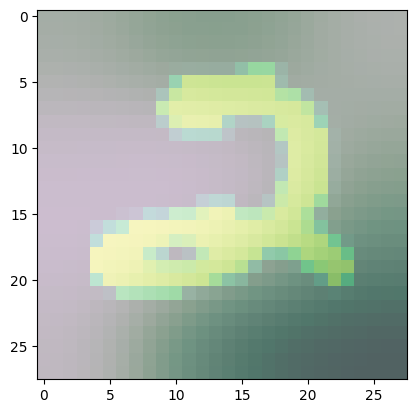

Predicted Class = 2, Probability = 0.99999636


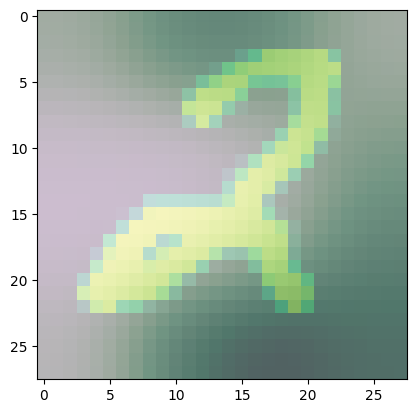

Predicted Class = 2, Probability = 0.99982095


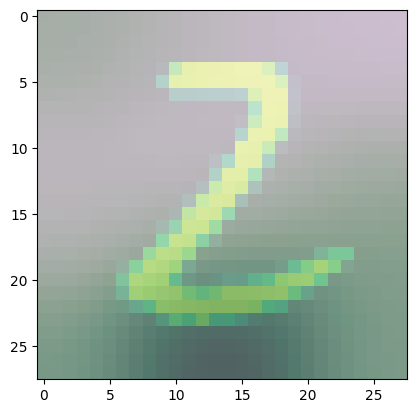

Predicted Class = 2, Probability = 0.9997637


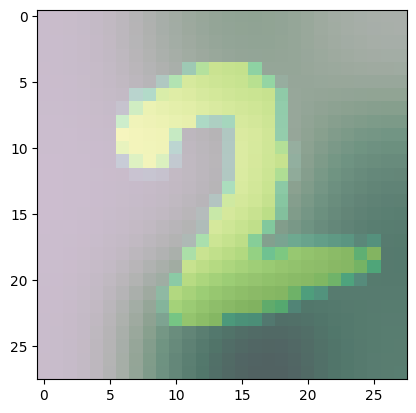

Predicted Class = 2, Probability = 0.9845733


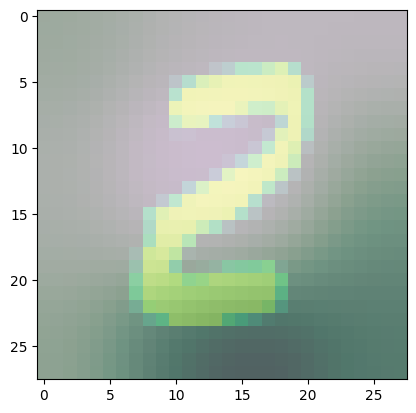

Predicted Class = 2, Probability = 0.9999425


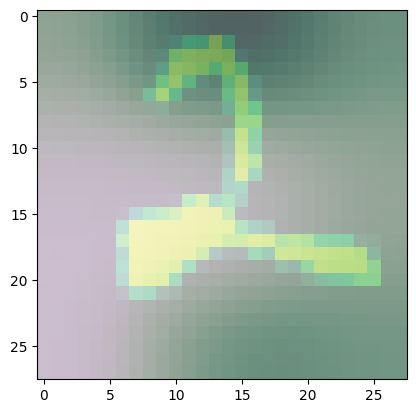

Predicted Class = 2, Probability = 0.9997308


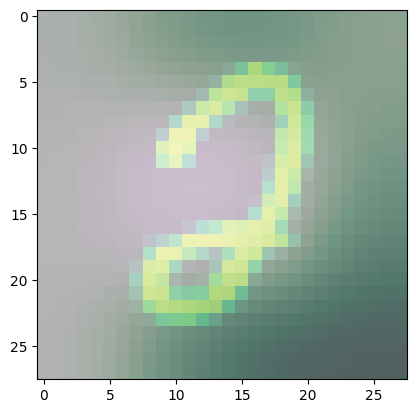

Predicted Class = 2, Probability = 0.96485907


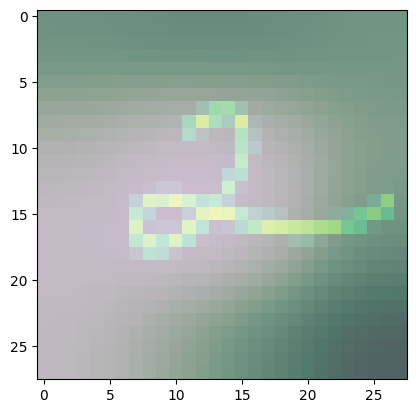

Predicted Class = 2, Probability = 0.99836886


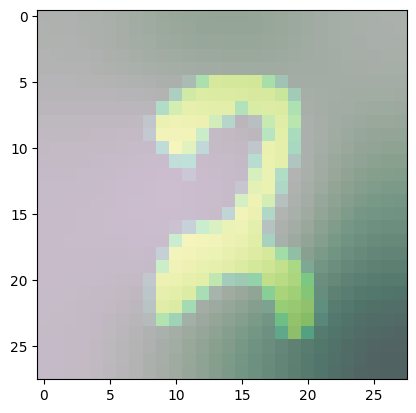

Predicted Class = 2, Probability = 0.9996855


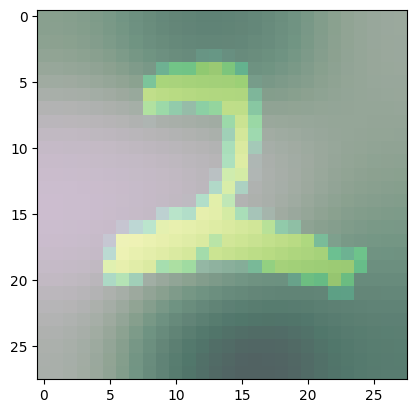

In [51]:
show_maps(2, 10)